In [1]:
running_on_colab = False
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
[]


In [3]:
# constants for program

input_bands = [i+1 for i in range(0,4)]
nBands = len(input_bands)
labels_band = 5

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/"
else: image_base_path = "./data/"

loadModel = True

Analyzing bands:  [1, 2, 3, 4]
nBands:  4


#### Getting training data

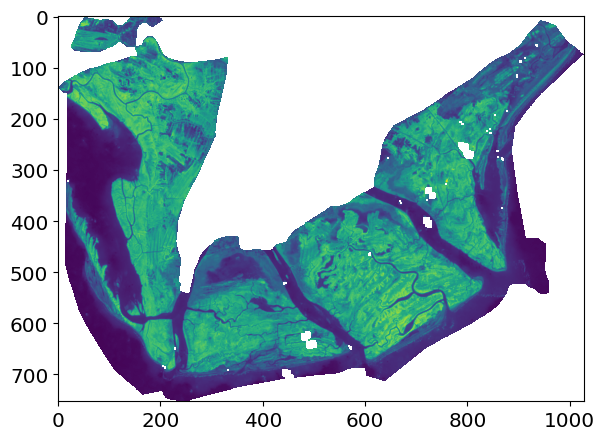

In [4]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/krishna_4_2022.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

In [5]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "krishna_4_2022.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)
mask = model_input_labels != -1
model_input_labels = model_input_labels[mask]
model_input_data = model_input_data[mask] 
max_val = np.max(model_input_data)
model_input_data = model_input_data/max_val

(4, 753, 1029)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
Using training data of length:  771277
class -1: 343947
class 0: 313629
class 1: 113701


#### Performing Hierarchical Clustering

In [6]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def batch_hierarchical_clustering(X, n_clusters, batch_size):
    # Initialize an empty list to store cluster labels
    cluster_labels = []
    
    # Determine the number of batches
    num_batches = int(np.ceil(len(X) / batch_size))
    
    # Perform clustering for each batch
    for i in range(num_batches):
        # Define the start and end indices for the current batch
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(X))
        
        # Extract the current batch from the data
        X_batch = X[start_index:end_index]
        
        # Perform hierarchical clustering on the current batch
        cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        labels_batch = cluster.fit_predict(X_batch)
        
        # Compute cluster means of the current batch
        cluster_means = [np.mean(X_batch[labels_batch == j], axis=0) for j in range(n_clusters)]
        
        # Determine which cluster mean[0] is greater
        greater_mean_index = np.argmax([mean[0] for mean in cluster_means])

        if greater_mean_index == 1:
            labels_batch = 1 - labels_batch
        labels_batch = 1 - labels_batch

        cluster_labels.extend(labels_batch)
        
    return np.array(cluster_labels)

# Sample data
random_state = 42
# Parameters
n_clusters = 2
batch_size = 20000

# Perform batch hierarchical clustering
cluster_labels = batch_hierarchical_clustering(model_input_data, n_clusters, batch_size)

# Print cluster labels
print("Cluster labels:", cluster_labels)

Cluster labels: [1 1 1 ... 0 0 0]


#### Labels from Hierarchical Clustering

shape (771277,)

Predicted mangroves:


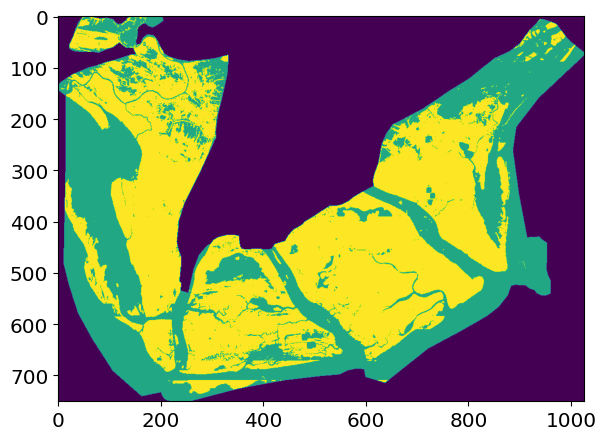

In [7]:
import matplotlib.pyplot as plt
count=0
mask=mask.ravel()
predict_new_final=[]
for i in range(len(mask)):
    if(mask[i]==False):
        predict_new_final.append(-1.5)
    else:
        predict_new_final.append(cluster_labels[count])
        count=count+1
print("shape",np.array(predict_new_final).shape)
prediction_new_image_2d=np.array(predict_new_final).reshape(751,1027)
# plot predicted mangroves
print('\nPredicted mangroves:')
plt.imshow(prediction_new_image_2d)

In [8]:
predict_new_final=np.array(predict_new_final)
predict_new_final=predict_new_final[mask]

In [9]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, predict_new_final, test_size=0.2, random_state=42, stratify=predict_new_final, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)

(341864, 1, 4)
(85466, 1, 4)


#### Training model using Multi Layer Perceptron by using the lables from Hierarchical Clustering

In [10]:
model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])


# sample_weight = np.ones(shape=(len(yTrain),))
# sample_weight[yTrain == -1] = 0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_dataset, epochs=10)

print(model.summary())

Epoch 1/10
5342/5342 [==============================] - 6s 1ms/step - loss: 0.2457 - accuracy: 0.8917
Epoch 2/10
5342/5342 [==============================] - 3s 631us/step - loss: 0.2225 - accuracy: 0.9040
Epoch 3/10
5342/5342 [==============================] - 3s 581us/step - loss: 0.2214 - accuracy: 0.9040
Epoch 4/10
5342/5342 [==============================] - 3s 567us/step - loss: 0.2212 - accuracy: 0.9039
Epoch 5/10
5342/5342 [==============================] - 3s 566us/step - loss: 0.2210 - accuracy: 0.9038
Epoch 6/10
5342/5342 [==============================] - 3s 566us/step - loss: 0.2203 - accuracy: 0.9039
Epoch 7/10
5342/5342 [==============================] - 4s 699us/step - loss: 0.2160 - accuracy: 0.9046
Epoch 8/10
5342/5342 [==============================] - 3s 644us/step - loss: 0.2132 - accuracy: 0.9053
Epoch 9/10
5342/5342 [==============================] - 3s 609us/step - loss: 0.2122 - accuracy: 0.9057
Epoch 10/10
5342/5342 [==============================] - 3s 596us/

In [11]:
# Predict for test data
yTest_pred_prob = model.predict(xTest)
print(yTest_pred_prob.shape)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1
print(yTest_pred_prob)
peu.printClassificationMetrics(yTest, yTest_pred_prob)

2671/2671 [==============================] - 1s 441us/step
(85466, 2)
[0.9999306  0.00932064 0.99996555 ... 0.9976706  0.74778056 0.85258955]
Confusion matrix:
 [[31649  5769]
 [ 2308 45740]]

P-Score: 0.888, R-Score: 0.952
Accuracy: 0.905
f1: 0.919
              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89     37418
         1.0       0.89      0.95      0.92     48048

    accuracy                           0.91     85466
   macro avg       0.91      0.90      0.90     85466
weighted avg       0.91      0.91      0.90     85466



0.9188705967435742



Predicting for image: ./data/krishna_4_2022.tif
(4, 753, 1029)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
13355/13355 [==============================] - 6s 450us/step
image (427330,)
shape (771277,)
hi 751 1027

Predicted mangroves:
Saving image:  SavedPlots/BasicNN/krishna_4/PredictedMangroves_krishna_4_2022.png


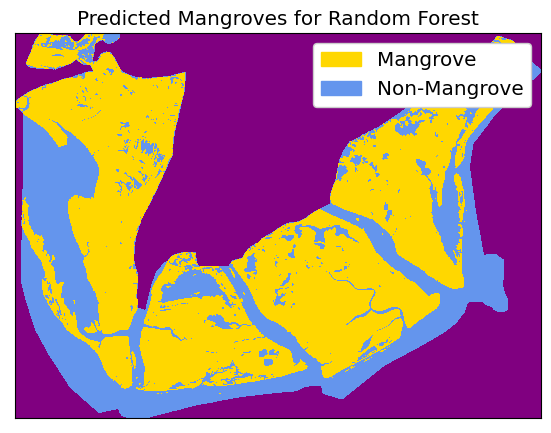

Saving image:  SavedPlots/BasicNN/krishna_4/GaL_krishna_4_2022.png


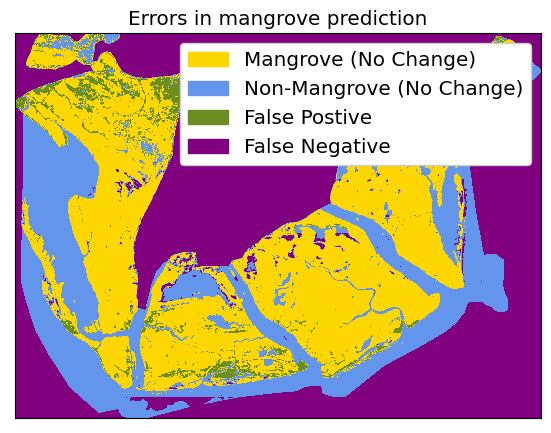

In [12]:
diu.predictOnImageUsingLabels(model, image_base_path + "krishna_4_2022.tif",cluster_labels)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

In [35]:
mlp_classifier = MLPClassifier(max_iter=1000, random_state=42)
gbc_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

#### Random Forest Classifier using the lables from Hierarchical Clustering

In [36]:
xTrain = xTrain.reshape((xTrain.shape[0], nBands))
xTest = xTest.reshape((xTest.shape[0], nBands))

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(xTrain, yTrain)

yPred = rf_classifier.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
print(accuracy)

0.9237006528912082




Predicting for image: ./data/krishna_4_2022.tif
(4, 753, 1029)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
image (427330,)
shape (771277,)
hi 751 1027

Predicted mangroves:
Saving image:  SavedPlots/BasicNN/krishna_4/PredictedMangroves_krishna_4_2022.png


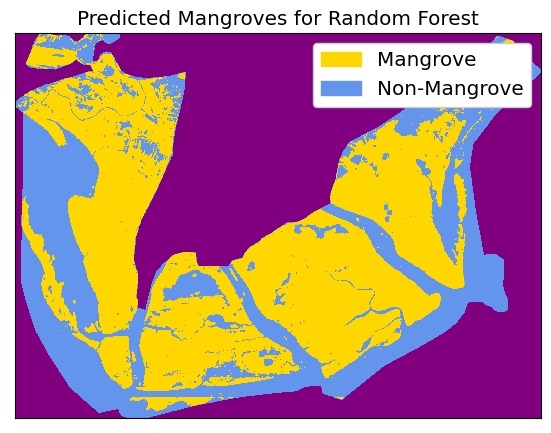

Saving image:  SavedPlots/BasicNN/krishna_4/GaL_krishna_4_2022.png


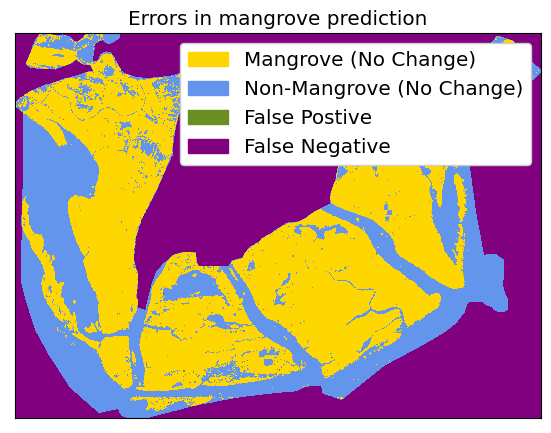

In [41]:
diu.predictOnImageRF(rf_classifier, image_base_path + "krishna_4_2022.tif",cluster_labels)

#### Gradrient Boosting Classifier using the lables from Hierarchical Clustering

In [38]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_classifier.fit(xTrain, yTrain)
yPred = gb_classifier.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(yTest, yPred))

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.88      0.90     37418
         1.0       0.91      0.95      0.93     48048

    accuracy                           0.92     85466
   macro avg       0.92      0.91      0.92     85466
weighted avg       0.92      0.92      0.92     85466





Predicting for image: ./data/krishna_4_2022.tif
(4, 753, 1029)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
image (427330,)
shape (771277,)
hi 751 1027

Predicted mangroves:
Saving image:  SavedPlots/BasicNN/krishna_4/PredictedMangroves_krishna_4_2022.png


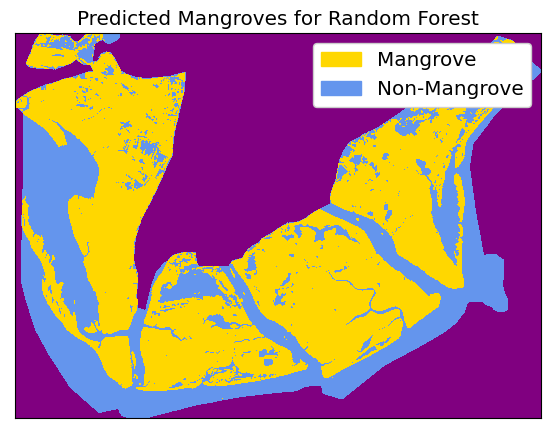

Saving image:  SavedPlots/BasicNN/krishna_4/GaL_krishna_4_2022.png


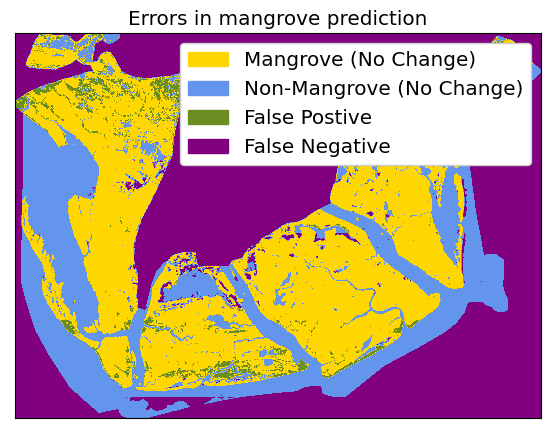

In [40]:
diu.predictOnImageRF(gb_classifier, image_base_path + "krishna_4_2022.tif",cluster_labels)